In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot
sns.set()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15840504778408098279
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16908965356939881831
physical_device_desc: "device: XLA_CPU device"
]


In [2]:
df1 = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')


def drop_columns(df, columns):
    df.drop(columns, axis=1,inplace=True)
    return df

def fill_NA(df, columns, value):
    for c in columns:
        df[c].fillna(value,inplace=True)
    return df

def get_dummies_for_category_columns(df):
    categoryColumns = df.columns[df.dtypes=="object"] 
    df = pd.concat([df,pd.get_dummies(df[categoryColumns])],axis=1)
    df.drop(categoryColumns, axis=1, inplace=True)
    return df

def drop_huge_buildings(df):
    # Drop huge buildings
    df=df[df["1stFlrSF"]<4000]
    df=df[df["LotArea"]<50000]
    df=df[df["BsmtFullBath"]<3] # why would you even have 3 bath in the basement?
    return df

def set_type(df, column, type_name):
    df[column] = df[column].astype(type_name)
    return df

def drop_non_correlated_columns(df, min_corr):
    salesPriceCorr = df.corr()['SalePrice']
    good_corr = np.logical_or(salesPriceCorr<-min_corr, salesPriceCorr>min_corr)
    onlyCorrelatedColumns = salesPriceCorr[good_corr]
    df = df[onlyCorrelatedColumns.index]
    return df

def log_tranform(df, column):
    df['log'+column] = np.log(df[column])
    return df;
    

In [3]:
# high NAN count
high_nan_columns = ['Alley','Electrical','FireplaceQu','PoolQC','Fence','MiscFeature','LotFrontage','GarageYrBlt']
no_variety_columns = ['Utilities','Condition2','Heating','PavedDrive','Street','BsmtCond','GarageFinish','GarageCond','GarageFinish','RoofMatl']
columnsToFillNone= ['MasVnrType','GarageQual', 'GarageType','BsmtFinType2','BsmtFinType1','BsmtExposure','BsmtQual']
columnsToFillZero= ['MasVnrArea',"BsmtFinSF1","BsmtFinSF2","TotalBsmtSF","BsmtFullBath","BsmtHalfBath","GarageCars","GarageArea" ] 
ignoreUncorrelatedRate = 0.2

def preprocess(df):
   return (df.pipe(drop_columns, columns=high_nan_columns) # high number of NA values 
   .pipe(drop_columns, columns=no_variety_columns) # no variety
   .pipe(drop_columns, columns=["Id","BsmtUnfSF", "BedroomAbvGr"])## drop Garbage
   .pipe(fill_NA, columns=columnsToFillNone, value='None') # 
   .pipe(fill_NA, columns=columnsToFillZero, value=0) # 
   .pipe(get_dummies_for_category_columns)
   .pipe(log_tranform, 'LotArea') 
   .pipe(set_type, 'MasVnrArea','int64')
)

df1 = preprocess(df1).pipe(drop_huge_buildings).pipe(drop_non_correlated_columns, min_corr=ignoreUncorrelatedRate) 
df2_ids=df2['Id']
df2 = preprocess(df2)

In [4]:
corr=df1.corr()
mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

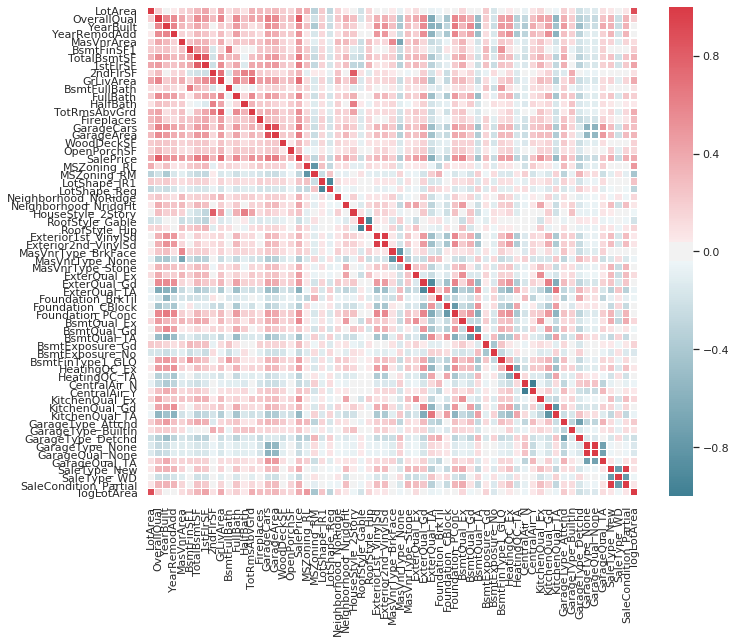

In [5]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": 1})

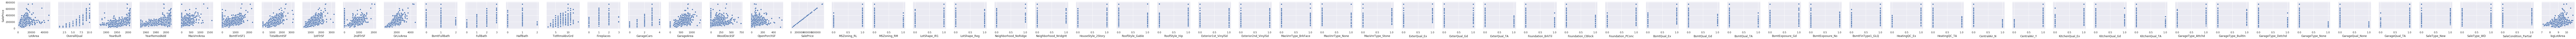

In [6]:
sns.pairplot(df1,y_vars=["SalePrice"], x_vars=df1.columns)


In [7]:
y = df1['SalePrice']
# X = df[['LotArea']]

X = df1.drop('SalePrice', axis=1)


In [8]:

# define model
model = Sequential()
model.add(Dense(25, input_dim=len(X.columns), activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='linear'))
# compile model
model.compile(loss='mean_squared_logarithmic_error', optimizer='adam')

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Use tf.cast instead.
Train on 1158 samples, validate on 290 samples
Epoch 1/100
1158/1158 [==============================] - 0s 241us/step - loss: 124.4202 - val_loss: 109.2277
Epoch 2/100
1158/1158 [==============================] - 0s 51us/step - loss: 101.4117 - val_loss: 93.7680
Epoch 3/100
1158/1158 [==============================] - 0s 58us/step - loss: 88.8534 - val_loss: 83.5103
Epoch 4/100
1158/1158 [==============================] - 0s 57us/step - loss: 80.1114 - val_loss: 76.2518
Epoch 5/100
1158/1158 [==============================] - 0s 44us/step - loss: 73.6186 - val_loss: 70.3119
Epoch 6/100
1158/1158 [==============================] - 0s 45us/step - loss: 67.9624 - val_loss: 65.1545
Epoch 7/100
1158/1158 [==============================] - 0s 58us/step - loss: 63.2660 - val_loss: 60.9519
Epoch 8/100
1158/1158 [==============================] - 0s 59us/step - loss: 59.4043 - val_loss: 57.4443
Epoch 9/100
1158/1158 [==============================

1158/1158 [==============================] - 0s 57us/step - loss: 11.6944 - val_loss: 11.5128
Epoch 75/100
1158/1158 [==============================] - 0s 57us/step - loss: 11.5037 - val_loss: 11.3244
Epoch 76/100
1158/1158 [==============================] - 0s 54us/step - loss: 11.3164 - val_loss: 11.1390
Epoch 77/100
1158/1158 [==============================] - 0s 50us/step - loss: 11.1320 - val_loss: 10.9568
Epoch 78/100
1158/1158 [==============================] - 0s 55us/step - loss: 10.9504 - val_loss: 10.7771
Epoch 79/100
1158/1158 [==============================] - 0s 52us/step - loss: 10.7716 - val_loss: 10.6003
Epoch 80/100
1158/1158 [==============================] - 0s 67us/step - loss: 10.5953 - val_loss: 10.4259
Epoch 81/100
1158/1158 [==============================] - 0s 60us/step - loss: 10.4219 - val_loss: 10.2538
Epoch 82/100
1158/1158 [==============================] - 0s 53us/step - loss: 10.2505 - val_loss: 10.0846
Epoch 83/100
1158/1158 [==========================

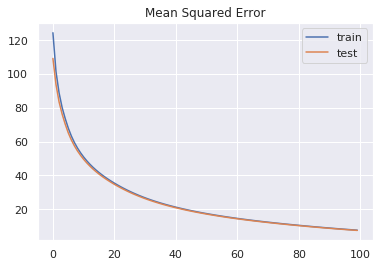

In [9]:


trainX, testX, trainy, testy = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=1)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaler.fit(trainX)
trainX= scaler.transform(trainX)
testX= scaler.transform(testX)
# fit model
history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=100, verbose=1)
# evaluate the model
train_mse = model.evaluate(trainX, trainy, verbose=0)
test_mse = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_mse, test_mse))
# plot loss during training
pyplot.title('Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
# pyplot.plot(history.history['acc'], label='train_acc')
# pyplot.plot(history.history['val_acc'], label='test_acc')
pyplot.legend()
pyplot.show()

In [10]:
df2.head()


,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,logLotArea
0,20,11622,5,6,1961,1961,0,468.0,144.0,882.0,896,0,0,896,0.0,0.0,1,0,1,5,0,1.0,730.0,140,0,0,0,120,0,0,6,2010,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0

In [11]:
df2.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_Bnk,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_Corner,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Gtl,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Fin,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Ex,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,ExterCond_Ex,ExterCond_Fa,ExterCond_Gd,ExterCond_Po,ExterCond_TA,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_None,BsmtQual_TA,BsmtExposure_Av,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_None,BsmtFinType1_ALQ,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_None,BsmtFinType1_Rec,BsmtFinType1_Unf,BsmtFinType2_ALQ,BsmtFinType2_BLQ,BsmtFinType2_GLQ,BsmtFinType2_LwQ,BsmtFinType2_None,BsmtFinType2_Rec,BsmtFinType2_Unf,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_2Types,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageQual_Fa,GarageQual_Gd,GarageQual_None,GarageQual_Po,GarageQual_TA,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,logLotArea
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.00000,1459.000000,1459.000000,1459.00

In [12]:
dfX=scaler.transform(df2[X.columns])

In [13]:
result = model.predict(dfX)

In [14]:
dfR = pd.DataFrame(df2_ids)
dfR['SalePrice']=result

In [15]:
dfR.describe()

,Id,SalePrice
count,1459.000000,1459.000000
mean,2190.000000,11011.160156
std,421.321334,1563.180786
min,1461.000000,5620.430176
25%,1825.500000,10001.295898
50%,2190.000000,10850.810547
75%,2554.500000,12158.145020
max,2919.000000,16539.880859


In [16]:
dfR.head()

,Id,SalePrice
0,1461,10534.680664
1,1462,10698.841797
2,1463,12879.257812
3,1464,13317.382812
4,1465,10597.531250


In [17]:
dfR.to_csv('predictions.csv',index = None, header=True)

In [18]:
df5 = pd.read_csv('test.csv')



In [19]:
df5['SaleType']

0          WD
1          WD
2          WD
3          WD
4          WD
5          WD
6          WD
7          WD
8          WD
9          WD
10         WD
11        COD
12         WD
13         WD
14         WD
15        New
16        New
17         WD
18         WD
19         WD
20         WD
21         WD
22         WD
23         WD
24         WD
25         WD
26         WD
27         WD
28        New
29         WD
30         WD
31         WD
32         WD
33         WD
34         WD
35         WD
36         WD
37      ConLD
38         WD
39         WD
40         WD
41         WD
42        New
43         WD
44         WD
45         WD
46         WD
47         WD
48         WD
49         WD
50      ConLD
51         WD
52        COD
53        Oth
54         WD
55         WD
56         WD
57         WD
58         WD
59         WD
60         WD
61         WD
62         WD
63         WD
64         WD
65         WD
66         WD
67         WD
68         WD
69         WD
70        COD
71    

In [20]:
predicted = model.predict(X)

In [21]:
df1['PredictedPrice']=predicted
df1['Delta'] = df1['SalePrice']-df1['PredictedPrice']


In [22]:
len(predicted)

1448

In [23]:
len(df1)

1448

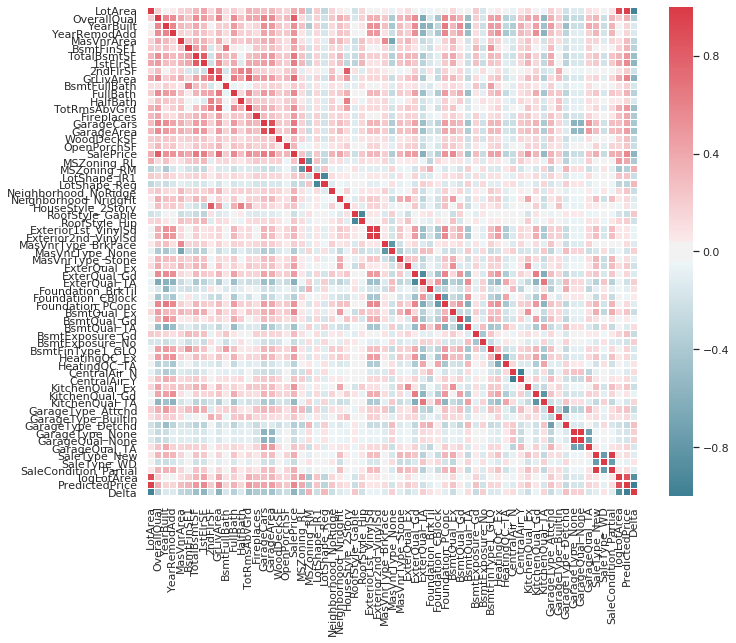

In [24]:
corr=df1.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": 1})

In [25]:
len(trainX)

1158